<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

    
  Почему была выбрана метрика f1?
  1. Метрика accuracy в нашем случае будет неточна, так как имеется несбалансированная выборка. Precision и recall как отдельные метрики интерпретируют результат модели по разному. В нашей задачи стоит учитывать одновременно полноту и точность, поэтому вступает метрика f1 (среднее гармоническое между этими полнотой и точностью).
    
А что если бы нам было нужно найти как можно больше токсичных комментариев, в этом случаи на какую метрику мы бы ориентировались?
 
 2. В случае, если мы хотим точнее определять токсичные комментарии, но тем самым жертвовать тем, что "хорошие" комментарии будут помечаны как токсичные, следует уменьшать FN – доля токсичных комментариев, которые классификатор пропускает. Так как полнота сможет определить, какую долю токсичных комментариев удалось выявить, она и будет являться требуемой метрикой.
    

## Подготовка

In [1]:
import re 
import math
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import RandomState
import pandas as pd
from sklearn.model_selection import GridSearchCV  
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from lightgbm import LGBMClassifier
from tqdm import tqdm

In [2]:
RANDOM_STATE = RandomState(12345) 

In [3]:
# nltk.download()

In [4]:
if os.path.exists('toxic_comments.csv'):
    data = pd.read_csv('toxic_comments.csv', index_col=0)
elif os.path.exists('/datasets/toxic_comments.csv'):
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
else:
    print('Something is wrong')

In [5]:
data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0


Проверим, какое соотношение между кол-вом токсичных и не токсичных сообщений. 

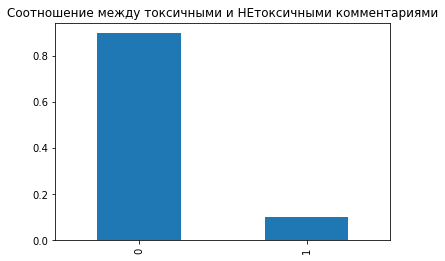

In [6]:
target_frequency = data['toxic'].value_counts(normalize=True)
target_frequency.plot(kind='bar') 
plt.title('Соотношение между токсичными и НЕтоксичными комментариями')
plt.show()

Исходя из полученной гистограммы видно, что в данных присутвует перевес нетоксичных комментариев, поэтому наши данные можно считать несбалансированными. Далее для борьбы с дисбалансом в моделях будет передан параметр class_weight':'balanced'.

В данных присутсвуют лишние символы и заглавные буквы, избавимся от них и приведем все к нижнему регистру:

In [7]:
def re_sub(text):   
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    text = text.split()
    text = " ".join(text)
    return text

In [8]:
data['text'] = data['text'].apply(re_sub)

In [9]:
data

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0
...,...,...
159446,and for the second time of asking when your vi...,0
159447,you should be ashamed of yourself that is a ho...,0
159448,spitzer umm theres no actual article for prost...,0
159449,and it looks like it was actually you who put ...,0


Построим функцию лемматизации

In [10]:
from nltk.tag.perceptron import PerceptronTagger
tagger = PerceptronTagger() 
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = tagger.tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
def lemmatiz(text):
    lemmatizer = WordNetLemmatizer()
    word_list = text.split()
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    return lemmatized_output


In [13]:
tqdm.pandas() 

In [14]:
data['text'] = data['text'].progress_apply(lemmatiz)


100%|██████████| 159292/159292 [07:35<00:00, 349.72it/s]


In [15]:
data

,text,toxic
0,explanation why the edits make under my userna...,0
1,daww he match this background colour im seemin...,0
2,hey man im really not try to edit war it just ...,0
3,more i cant make any real suggestion on improv...,0
4,you sir be my hero any chance you remember wha...,0
...,...,...
159446,and for the second time of ask when your view ...,0
159447,you should be ashamed of yourself that be a ho...,0
159448,spitzer umm there no actual article for prosti...,0
159449,and it look like it be actually you who put on...,0


Функция разделения данных на тестовые и тренировочные

In [16]:
def get_features_target(data=data):
    features_train, features_test, target_train, target_test = train_test_split(data['text'], data['toxic'], test_size=0.1, random_state=RANDOM_STATE, stratify=data['toxic'])
    return features_train, features_test, target_train, target_test

А стопслова важней убирать когда мы используем TF-IDF, или когда используе обычный CountVectorizer?

Могу предположить, что в CountVectorizer важнее избавляться от стоп-слов, так как он ищет частоту появления слова в тексте, и скорее всего самыми важными словами и будут те, которые появляются чаще всего. Про TF-IDF прочитала, что TF-IDF придает большую ценность редким словам, чем очень повторяющимся токенам.


In [18]:
features_train, features_test, target_train, target_test = get_features_target()

In [19]:
pipe = Pipeline(steps = [('vect', TfidfVectorizer(stop_words=set(nltk_stopwords.words('english')))),
                         ("classifier", LGBMClassifier(random_state=RANDOM_STATE))])

search_space = [                    {"classifier": [LGBMClassifier(random_state=RANDOM_STATE)],
                                   "classifier__n_estimators": range(100, 500, 100),
                                   "classifier__num_leaves": [2**1, 2**2, 2**3, 2**4, 2**5],
                                   'classifier__class_weight':['balanced'],
                                   "classifier__learning_rate": [0.0001, 0.001, 0.01, 0.1, 1.0]},
                                     {"classifier": [LogisticRegression(random_state=RANDOM_STATE)],
                                   "classifier__C": [0.001,0.01,0.1,1,10,100], 
                                   'classifier__class_weight':['balanced'],
                                   'classifier__max_iter':[100,150,200],
                                   'classifier__solver':['liblinear']
                    }
                    ]
clf = GridSearchCV(pipe, search_space, cv=4, scoring='f1',return_train_score=True, n_jobs=-1)



## Обучение

In [20]:
best_model = clf.fit(features_train, target_train)

In [21]:
print(best_model.best_score_)
print(best_model.best_params_)

0.7599910954627525
{'classifier': LogisticRegression(C=10, class_weight='balanced',
                   random_state=RandomState(MT19937) at 0x21B11149240,
                   solver='liblinear'), 'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__max_iter': 100, 'classifier__solver': 'liblinear'}


С помщью Pipeline и  GridSearchCV была найдена лучшая модель:  LogisticRegression(C=10, class_weight='balanced', max_iter=100, solver='liblinear')

In [30]:
predictions=best_model.predict(features_test)

In [31]:
f1_score(target_test,predictions)

0.765024209626887

## Выводы

При решении задачи классификации токсичности текста были изучены методы предварительной обработки текста, подобрана лучшая модель для классификации текста, содержащего токсичные высказывания, c помощью Pipeline + GridSearchCV. Итоговой лучшей моделью оказалась модель LogisticRegression, которая на тестовой выборки показала значение метрики f1-score равный 0.765. Данная модель обучалась на целиковом датасете.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны